# Payment Analysis

## Purpose
Finding insight on :
- **What is the "prefered" way to pay for user?**
- **What type of payment is used on big value payment and why?**
- **What can we do regarding the payment method to increase new user (recommendation)?** 

## Background
In ecommerce, payment analytics may help us to make better business decision. For example by understanding local conversion rate & preferred payment type, we could give better discount & cashback that are more likely increase the number of sales.

Also, we can also reduce the number of abandonment rate for new user user when they check out the basket by providing payment types & benefit that were more likely to be used by them. Based on a number of different ecommerce studies, the average shopping cart abandonment rate is 68.81% with the most recent study showing 74.52%. [reference](https://www.geckoboard.com/best-practice/kpi-examples/shopping-cart-abandonment-rate/#:~:text=Based%20on%20a%20number%20of,most%20recent%20study%20showing%2074.52%25.). 

Depending on the country & local customer, the e-payment method used might different too. That's why this payment analysis purpose is to try to identify the characteristic for payment type used by local customer, and ways to improve it.

## Assumption
Before we do analysis, generally e-payment is divided into 3 categories:
- credit based
- alternative e-payment (various implementation, but always use bank as transaction medium)
- digital wallet (3rd party)

Based on research ([reference](https://www.jpmorgan.com/merchant-services/insights/reports/indonesia)), we can see that the e-payment trend in Indonesia are credit card and bank usage (debit). Meanwhile regulation in Indonesia still hinder the growth for digital wallet, but we could see the rise on popularity for the digital wallet based payment.

## Sanity Check

In [1]:
import json

def load_config(file_path: str = "./config.json"):
    with open(file_path) as config_file:
        data = json.load(config_file)
    return data

config = load_config("../config.json")
DBNAME = config.get("DBNAME")
HOSTNAME = config.get("HOSTNAME")
USER = config.get("USER")
PASS = config.get("PASS")
SCHEMA = config.get("SCHEMA")

In [2]:
# Basic 
import sys
import numpy as np
import scipy as sp
import pandas as pd

# SQL Engine
import psycopg2
import pandas as pd
from sqlalchemy import create_engine

# Profiling process
from tqdm import tqdm

# Warning problems in notebook
import warnings
warnings.filterwarnings('ignore')

# Visualization
import bamboolib as bam
import plotly.express as px

# Reporting result
import sweetviz as sv
from dataprep.eda import create_report

In [3]:
# Load data

# Create an engine instance
alchemyEngine = create_engine(
    f'postgresql+psycopg2://{USER}:{PASS}@{HOSTNAME}/{DBNAME}', pool_recycle=3600)

# Connect to PostgreSQL server
conn = alchemyEngine.connect()

schema = SCHEMA

In [4]:
# Init needed data

QUERY = """
-- Payment Datamart
-- Datamart 5
select 
	foi.order_id ,
	MAX(foi.num_blipay) as num_blipay,
	MAX(foi.num_credit_card) as num_credit_card,
	MAX(foi.num_debit) as num_debit,
	MAX(foi.num_voucher) as num_voucher,
	MAX(foi.num_unknown) as num_unknown,
	MAX(foi.total_payment_blipay) as total_payment_blipay,
	MAX(foi.total_payment_credit_card) as total_payment_credit_card,
	MAX(foi.total_payment_debit) as total_payment_debit,
	MAX(foi.total_payment_voucher) as total_payment_voucher,
	MAX(foi.total_payment_unknown) as  total_payment_unknown
from staging.fct_order_items foi 
group by 1
order by 3 desc ,2 desc ,4 desc ,5 desc , 6 desc;
"""

# Init dataframe
df = pd.read_sql_query(QUERY, conn)
df["payment_per_installment_blipay"] = df['total_payment_blipay'] / df['num_blipay']
df["payment_per_installment_credit"] = df['total_payment_credit_card'] / df['num_credit_card']
df["payment_per_installment_debit"] = df['total_payment_debit'] / df['num_debit']
df["payment_per_installment_voucher"] = df['total_payment_voucher'] / df['num_voucher']
df

order_id  num_blipay  num_credit_card  \
0      1d3b8d78074e0b50f10346941e67e9de           0                2   
1      0cd93455c51655ebb590c07a06d584a1           0                2   
2      1d251ab94983c4adb11e4b168abb1439           0                2   
3      34a0185eb0d4d88d2ad9af1bd62d6a45           0                2   
4      2dd1b3fcb05d15852bfc51a0a8405381           0                2   
...                                 ...         ...              ...   
98661  5a9c1337a1f6bb21e46fc043cf2c26c5           0                0   
98662  7c2ee08449e6b8b55158e518778dbe83           0                0   
98663  72a052a9ab8a74244365ab1abf627bf3           0                0   
98664  5102eb8dd13b0cc9991a7686a229e96f           0                0   
98665  bfbd0f9bdef84302105ad712db648a6c           0                0   

       num_debit  num_voucher  num_unknown  total_payment_blipay  \
0              0            1            0                   0.0   
1              0            1            0                   0.0   
2              0            1            0                   0.0   
3              0            0            0                   0.0   
4              0            0            0                   0.0   
...          ...          ...          ...                   ...   
98661          0            1            0                   0.0   
98662          0            1            0                   0.0   
98663          0            1            0                   0.0   
98664          0            1            0                   0.0   
98665          0            0            0                   0.0   

       total_payment_credit_card  total_payment_debit  total_payment_voucher  \
0                       125230.0                  0.0                26070.0   
1                       361070.0                  0.0                17540.0   
2                       184520.0                  0.0                53890.0   
3                       296120.0                  0.0                    0.0   
4                       153020.0                  0.0                    0.0   
...                          ...                  ...                    ...   
98661                        0.0                  0.0                24000.0   
98662                        0.0                  0.0                12890.0   
98663                        0.0                  0.0                23710.0   
98664                        0.0                  0.0                35960.0   
98665                        0.0                  0.0                    0.0   

       total_payment_unknown  payment_per_installment_blipay  \
0                        0.0                             NaN   
1                        0.0                             NaN   
2                        0.0                             NaN   
3                        0.0                             NaN   
4                        0.0                             NaN   
...                      ...                             ...   
98661                    0.0                             NaN   
98662                    0.0                             NaN   
98663                    0.0                             NaN   
98664                    0.0                             NaN   
98665                    0.0                             NaN   

       payment_per_installment_credit  payment_per_installment_debit  \
0                             62615.0                            NaN   
1                            180535.0                            NaN   
2                             92260.0                            NaN   
3                            148060.0                            NaN   
4                             76510.0                            NaN   
...                               ...                            ...   
98661                             NaN                            NaN   
98662                             NaN      

In [37]:
blipay_num = df.loc[df.num_blipay > 0].num_blipay.agg(['sum', 'count', 'mean', 'max'])
blipay_num

sum      19614.0
count    19614.0
mean         1.0
max          1.0
Name: num_blipay, dtype: float64

In [38]:
credit_num = df.loc[df.num_credit_card > 0].num_credit_card.agg(['sum', 'count', 'mean', 'max'])
credit_num

sum      76278.000000
count    75991.000000
mean         1.003777
max          2.000000
Name: num_credit_card, dtype: float64

In [39]:
debit_num = df.loc[df.num_debit > 0].num_debit.agg(['sum', 'count', 'mean', 'max'])
debit_num

sum      1522.000000
count    1521.000000
mean        1.000657
max         2.000000
Name: num_debit, dtype: float64

In [40]:
voucher_num = df.loc[df.num_voucher > 0].num_voucher.agg(['sum', 'count', 'mean', 'max'])
voucher_num

sum      5642.000000
count    3766.000000
mean        1.498141
max        29.000000
Name: num_voucher, dtype: float64

In [41]:
blipay_val = df.loc[df.total_payment_blipay > 0].total_payment_blipay.agg(['sum', 'mean'])
blipay_val

sum     2.842240e+09
mean    1.449087e+05
Name: total_payment_blipay, dtype: float64

In [42]:
credit_val = df.loc[df.total_payment_credit_card > 0].total_payment_credit_card.agg(['sum', 'mean'])
credit_val

sum     1.243623e+10
mean    1.636539e+05
Name: total_payment_credit_card, dtype: float64

In [43]:
debit_val = df.loc[df.total_payment_debit > 0].total_payment_debit.agg(['sum', 'mean'])
debit_val

sum     2.151057e+08
mean    1.414239e+05
Name: total_payment_debit, dtype: float64

In [44]:
voucher_val = df.loc[df.total_payment_voucher > 0].total_payment_voucher.agg(['sum', 'mean'])
voucher_val.values

array([3.52707710e+08, 9.36557913e+04])

In [45]:
blipay_installment = df.loc[df.payment_per_installment_blipay > 0].payment_per_installment_blipay.agg(['sum', 'mean'])
blipay_installment

sum     2.842240e+09
mean    1.449087e+05
Name: payment_per_installment_blipay, dtype: float64

In [46]:
credit_installment = df.loc[df.payment_per_installment_credit > 0].payment_per_installment_credit.agg(['sum', 'mean'])
credit_installment

sum     1.238629e+10
mean    1.629968e+05
Name: payment_per_installment_credit, dtype: float64

In [47]:
debit_installment = df.loc[df.payment_per_installment_debit > 0].payment_per_installment_debit.agg(['sum', 'mean'])
debit_installment

sum     2.150826e+08
mean    1.414087e+05
Name: payment_per_installment_debit, dtype: float64

In [48]:
voucher_installment = df.loc[df.payment_per_installment_voucher > 0].payment_per_installment_voucher.agg(['sum', 'mean'])
voucher_installment

sum     2.953011e+08
mean    7.841241e+04
Name: payment_per_installment_voucher, dtype: float64

In [49]:
payment = pd.DataFrame({
    "blipay" : [blipay_num.values[0], blipay_num.values[1], blipay_num.values[2], blipay_num.values[3], blipay_val.values[0], blipay_val.values[1], blipay_installment.values[0], blipay_installment.values[1]],
    "credit" : [credit_num.values[0], credit_num.values[1], credit_num.values[2], credit_num.values[3], credit_val.values[0], credit_val.values[1], credit_installment.values[0], credit_installment.values[1]], 
    "debit" : [debit_num.values[0], debit_num.values[1], debit_num.values[2], debit_num.values[3], debit_val.values[0], debit_val.values[1], debit_installment.values[0], debit_installment.values[1]],
    "voucher" : [voucher_num.values[0], voucher_num.values[1], voucher_num.values[2], voucher_num.values[3], voucher_val.values[0], voucher_val.values[1], voucher_installment.values[0], voucher_installment.values[1]]
})
payment = payment.T
payment.columns = ['total_usage', 'order_count', 'installment_avg', 'installment_max', 'total_value', 'avg_value', 'total_installment_value ', 'avg_installment_value']
payment = payment.reset_index()
payment

total_usage  order_count  installment_avg  installment_max  \
blipay       19614.0      19614.0         1.000000              1.0   
credit       76278.0      75991.0         1.003777              2.0   
debit         1522.0       1521.0         1.000657              2.0   
voucher       5642.0       3766.0         1.498141             29.0   

          total_value      avg_value  total_installment_value   \
blipay   2.842240e+09  144908.746814              2.842240e+09   
credit   1.243623e+10  163653.940203              1.238629e+10   
debit    2.151057e+08  141423.885602              2.150826e+08   
voucher  3.527077e+08   93655.791290              2.953011e+08   

         avg_installment_value  
blipay           144908.746814  
credit           162996.775934  
debit            141408.698225  
voucher           78412.405348

## Preferred way to pay in Ecommerce

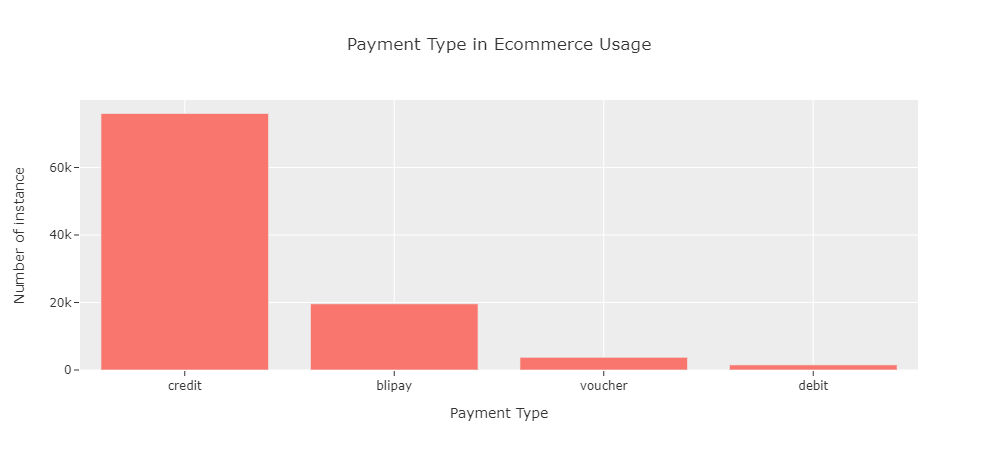

In [50]:
import plotly.express as px
fig = px.bar(payment, x=payment.index, y='order_count', template='ggplot2', title='Payment Type in Ecommerce Usage')
fig.update_xaxes( type='category')
# To sorting : Uncomment below
fig.update_xaxes(categoryorder='total descending')
fig.update_xaxes(title_text='Payment Type')
fig.update_yaxes(title_text='Number of instance')
fig

Based on usage for paying order, we could see that **credit card** is the "preferred" method for payment, and then followed by blipay. Based on this [reference](https://www.blibli.com/faq/blipay/apa-itu-blipay/), blipay is similar to digital wallet that have a saving to pay for service provided by Blibli.com (digital wallet)

We could see that the other payment type (debit & voucher) is not used as frequent as the "preferred" method for payment.

## What is the average value for transaction of each payment type?

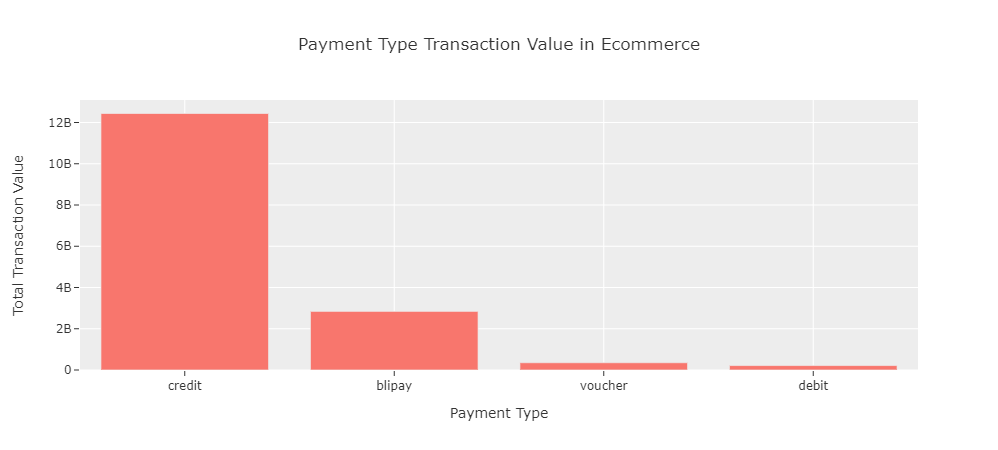

In [51]:
import plotly.express as px
fig = px.bar(payment, x=payment.index, y='total_value', template='ggplot2', 
             title='Payment Type Transaction Value in Ecommerce')
fig.update_xaxes( type='category')
# To sorting : Uncomment below
fig.update_xaxes(categoryorder='total descending')
fig.update_xaxes(title_text='Payment Type')
fig.update_yaxes(title_text='Total Transaction Value')
fig

From above graph, we could see that credit card have biggest total transaction value. But this result may be biased because credit card is the most used payment type (previous graph). 

Let see average payment (per installment) for each payment type...

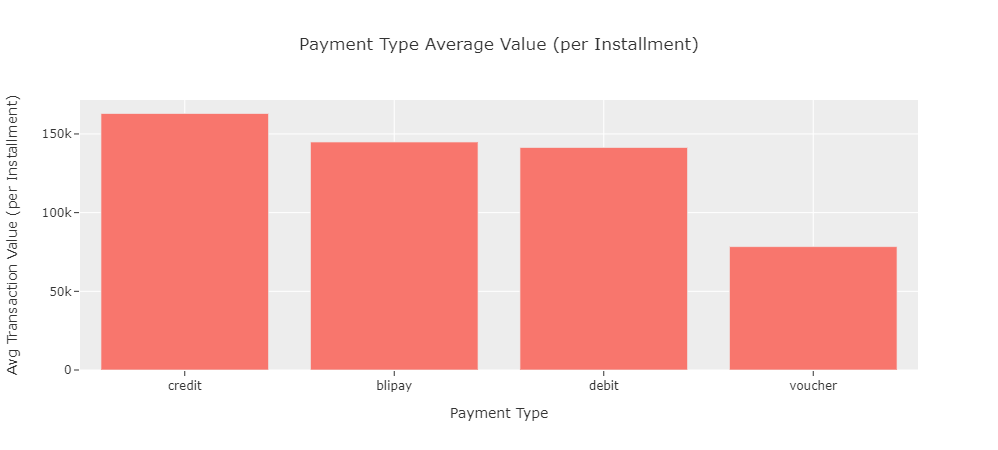

In [52]:
fig = px.bar(payment, x=payment.index, y='avg_installment_value', template='ggplot2', 
             title='Payment Type Average Value (per Installment)')
fig.update_xaxes( type='category')
# To sorting : Uncomment below
fig.update_xaxes(categoryorder='total descending')
fig.update_xaxes(title_text='Payment Type')
fig.update_yaxes(title_text='Avg Transaction Value (per Installment)')
fig

Here, we see that for each installment, credit card still have the most value for payment, followed by blipay and credit. 

Looks like voucher is used for payment that were less than 100k (about 78k).

In [53]:
# Boxplot preparation

blipay_total_transaction = pd.DataFrame({
    "total_payment" : [],
    "type":[]
})
blipay_total_transaction.total_payment = df.loc[df.total_payment_blipay > 0].total_payment_blipay
blipay_total_transaction.type = "blipay"
blipay_total_transaction
credit_total_transaction = pd.DataFrame({
    "total_payment" : [],
    "type":[]
})
credit_total_transaction.total_payment = df.loc[df.total_payment_credit_card > 0].total_payment_credit_card
credit_total_transaction.type = "credit"

debit_total_transaction = pd.DataFrame({
    "total_payment" : [],
    "type":[]
})
debit_total_transaction.total_payment = df.loc[df.total_payment_debit > 0].total_payment_debit
debit_total_transaction.type = "debit"

voucher_total_transaction = pd.DataFrame({
    "total_payment" : [],
    "type":[]
})
voucher_total_transaction.total_payment = df.loc[df.total_payment_voucher > 0].total_payment_voucher
voucher_total_transaction.type = "voucher"

total_transaction = pd.concat([blipay_total_transaction,credit_total_transaction,debit_total_transaction,voucher_total_transaction], ignore_index=True)
total_transaction

total_payment     type
0            220710.0   blipay
1             32000.0   blipay
2             59390.0   blipay
3            143460.0   blipay
4            117270.0   blipay
...               ...      ...
100887        63010.0  voucher
100888        24000.0  voucher
100889        12890.0  voucher
100890        23710.0  voucher
100891        35960.0  voucher

[100892 rows x 2 columns]

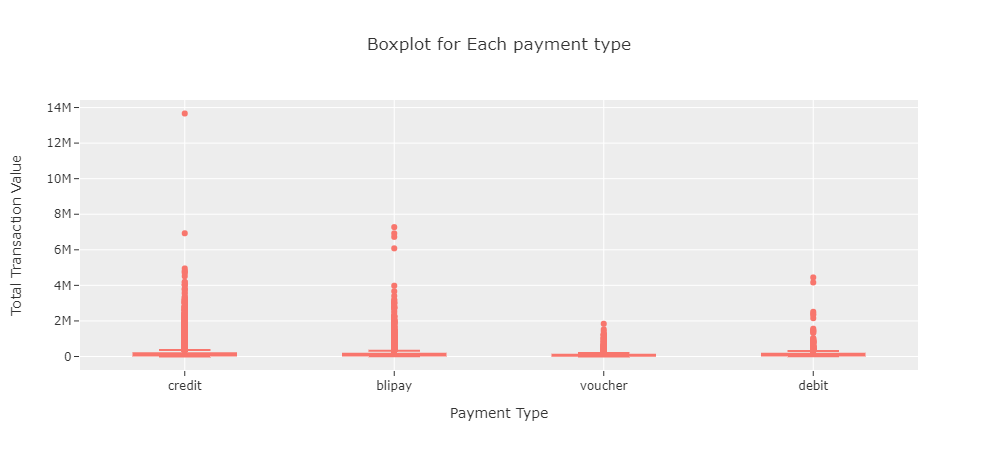

In [54]:
fig = px.box(total_transaction.sort_index(), x='type', y='total_payment', template='ggplot2', title="Boxplot for Each payment type")
fig.update_xaxes( type='category')
# To sorting : Uncomment below
fig.update_xaxes(categoryorder='total descending')
fig.update_xaxes(title_text='Payment Type')
fig.update_yaxes(title_text='Total Transaction Value')
fig

Based on the boxplot, we could see many outlier from credit, blipay and debit for each transaction (order). From the outlier, we could see that most likely people will use either credit card for high value transaction.

What about installment? How many installment normally happen for each payment type

In [66]:
def customLegend(fig, nameSwap):
    for i, dat in enumerate(fig.data):
        for elem in dat:
            if elem == 'name':
                print(fig.data[i].name)
                fig.data[i].name = nameSwap[fig.data[i].name]
    return(fig)

wide_variable_0
wide_variable_1


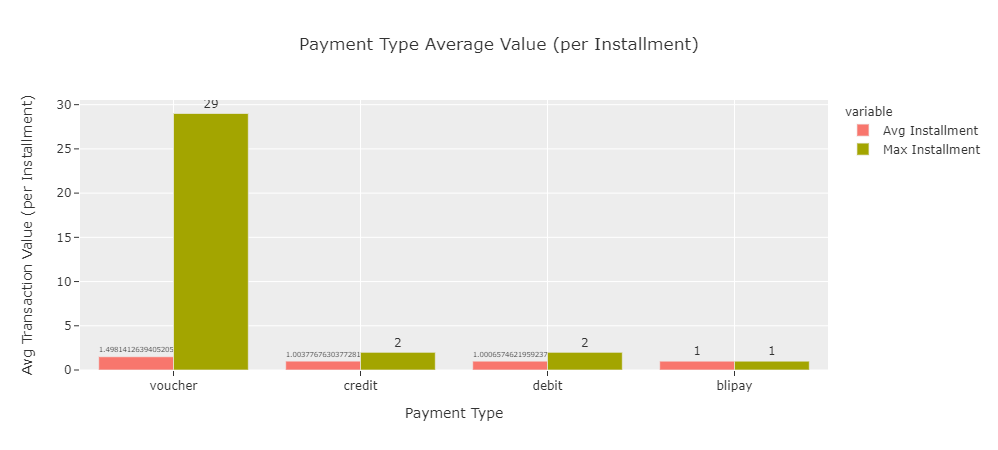

In [67]:
fig = px.bar(x=payment.index, y=[payment.installment_avg, payment.installment_max], template='ggplot2',barmode='group',
             title='Payment Type Average Value (per Installment)')
fig.update_xaxes( type='category')
# To sorting : Uncomment below
fig.update_xaxes(categoryorder='total descending')
fig.update_xaxes(title_text='Payment Type')
fig.update_yaxes(title_text='Avg Transaction Value (per Installment)')
texts = [payment.installment_avg, payment.installment_max]
for i, t in enumerate(texts):
    fig.data[i].text = t
    fig.data[i].textposition = 'outside'
fig = customLegend(fig, {"wide_variable_0": "Avg Installment", "wide_variable_1": "Max Installment"})
fig

## Insight

There are various notes that we can get from the payment analysis:  
- Based on boxplot, it seems that there are extreme outliers from transaction value payment. This means that for higher value of transactions ,people prefer to buy using credit card, maybe because they can pay later using this method (installment handled by the credit card party).
- Transaction using blipay is also multimodal, and seems like for lesser value even though still dominated by outliers.
- The most "preferred" way of paying is by using credit card followed by blipay.
- Debit and voucher are not used much as the other payment method.

## Recommendation

Based on insight that we get from the payment analysis, we can recommend few things:
- In order to decrease the abondonment rates in checkout process because of payment method, might use A/B Testing E-Payment Methods to find out the best payment method for this ecommerce.
Benefit : Lower abandonment rate, Reduced customer acquisition cost and increase profit (because of lower abondonment rate).
- Might give special discount (from pairing with specific credit card), because it seems like customer from this ecommerce "prefer" to use credit card as payment method.
- Also might be able to give some "cashback" from using digital wallet like blipay to increase the usage of blipay, as we can see in the increasing Indonesian trend to use digital wallet  

## Reference : 
- [Ecommerce e-payment method](https://extension.psu.edu/e-commerce-payment-methods)
- [The need of payment analytics](https://home.bluesnap.com/snap-center/blog/ecommerce-payment-analytics/)
- [Reduce Abondenment Rate](https://towardsdatascience.com/how-to-reduce-abandonment-rate-during-the-e-commerce-checkout-stage-a-b-testing-e-payment-methods-8818506a353c)
- [e-payment Trend Indonesia](https://www.jpmorgan.com/merchant-services/insights/reports/indonesia)